In [1]:
import numpy as np
import pandas as pd
import os
from time import time

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from hmmlearn import hmm
import tensorflow as tf
from tensorflow import keras
from keras.layers import *
from keras.models import *
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Dropout
from keras.callbacks import ReduceLROnPlateau
plt.style.use('fivethirtyeight')

import warnings

warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('Huge Stock Market\Stocks\msft.us.txt')
df

,Date,Open,High,Low,Close,Volume,OpenInt
0,1986-03-13,0.06720,0.07533,0.06720,0.07533,1371330506,0
1,1986-03-14,0.07533,0.07533,0.07533,0.07533,409569463,0
2,1986-03-17,0.07533,0.07533,0.07533,0.07533,176995245,0
3,1986-03-18,0.07533,0.07533,0.07533,0.07533,90067008,0
4,1986-03-19,0.07533,0.07533,0.07533,0.07533,63655515,0
...,...,...,...,...,...,...,...
7978,2017-11-06,84.20000,84.70000,84.08250,84.47000,19852151,0
7979,2017-11-07,84.77000,84.90000,83.93000,84.26000,17927878,0
7980,2017-11-08,84.14000,84.61000,83.83000,84.56000,18029584,0
7981,2017-11-09,84.11000,84.27000,82.90000,84.09000,21175384,0


In [4]:
df.shape

(7983, 7)

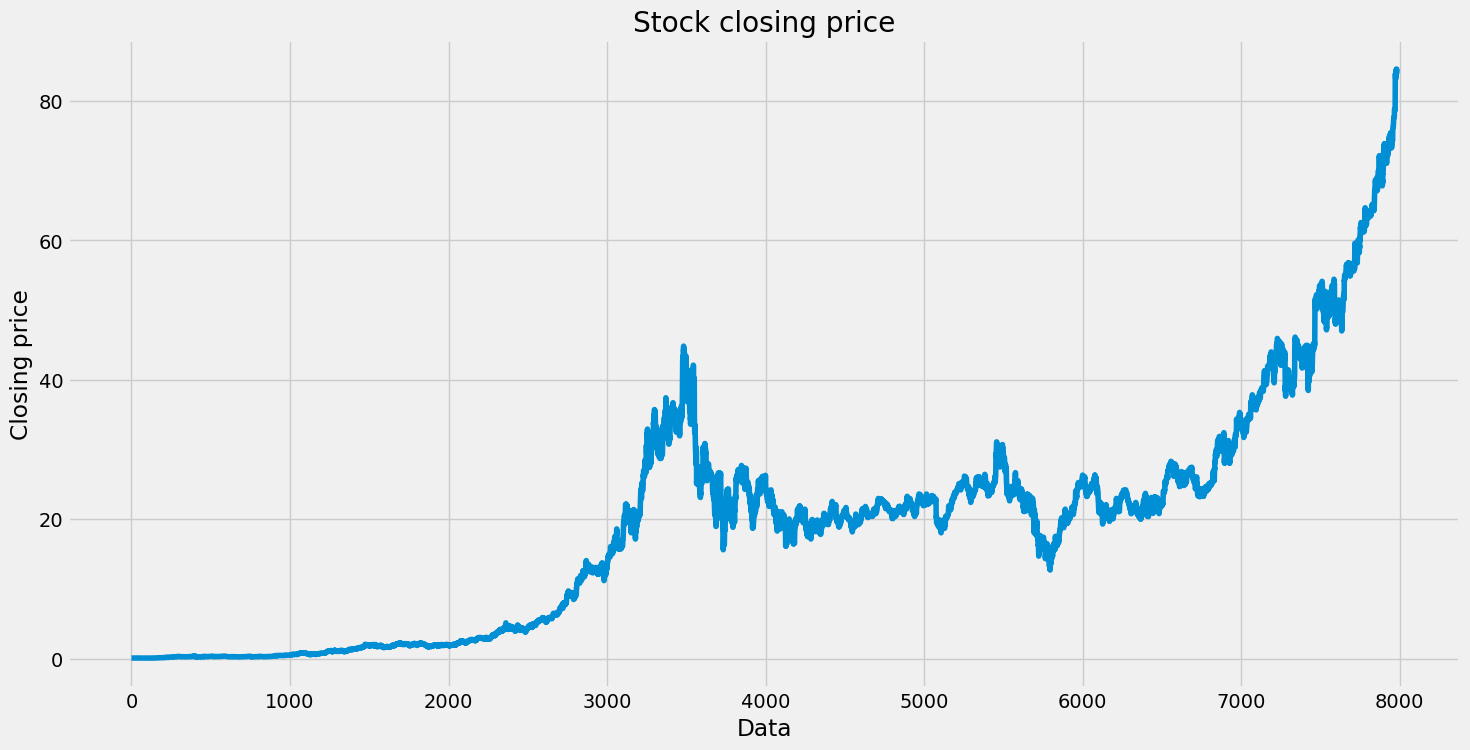

In [5]:
#visualize the closing prices
plt.figure(figsize=(16,8))
plt.title('Stock closing price')
plt.plot(df["Close"])
plt.xlabel('Data')
plt.ylabel('Closing price')
plt.show()

# Data Preprocessing #

In [6]:
# Extract the 'Close' prices, which is typically the target variable for stock market prediction tasks.
data = df.filter(['Close'])
dataset = data.values

# Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(dataset)

The data is scaled using StandardScaler to normalize it before feeding it into the machine learning models. This is a common preprocessing step to ensure that all features have a similar scale, which helps with performance.

In [7]:
# Define a function to split data into training and testing sets
def split_data(data, train_size):
    train_size = int(len(data) * train_size)
    train_data = data[:train_size]
    test_data = data[train_size:]
    return train_data, test_data

# Split the data into training and testing sets
train_data, test_data = split_data(scaled_data, train_size=0.8)

In [8]:
print(train_data)
print(test_data)

[[-1.15139665]
 [-1.15139665]
 [-1.15139665]
 ...
 [ 0.22001493]
 [ 0.2276871 ]
 [ 0.2127081 ]]
[[0.20795865]
 [0.2127081 ]
 [0.20442702]
 ...
 [3.99289816]
 [3.96427973]
 [3.95088387]]


# HMM Process #

In [9]:
# Define the number of hidden states for the HMM model
num_hidden_states = 4

# Build the HMM model
hmm_model = hmm.GaussianHMM(n_components=num_hidden_states, covariance_type="diag", n_iter=100)

# Train the HMM model
hmm_model.fit(train_data)

# Predict hidden states for training and testing data
hidden_states_train = hmm_model.predict(train_data)
hidden_states_test = hmm_model.predict(test_data)

# Combine original features with HMM predictions
hmm_train = np.concatenate((train_data, hidden_states_train.reshape(-1, 1)), axis=1)
hmm_test = np.concatenate((test_data, hidden_states_test.reshape(-1, 1)), axis=1)

In [10]:
print(hmm_train)
print(hmm_test)

[[-1.15139665  0.        ]
 [-1.15139665  0.        ]
 [-1.15139665  0.        ]
 ...
 [ 0.22001493  1.        ]
 [ 0.2276871   3.        ]
 [ 0.2127081   1.        ]]
[[0.20795865 0.        ]
 [0.2127081  2.        ]
 [0.20442702 3.        ]
 ...
 [3.99289816 2.        ]
 [3.96427973 2.        ]
 [3.95088387 2.        ]]



- In the code snippet above, a Gaussian Hidden Markov Model (HMM) is instantiated using the GaussianHMM class from the hmmlearn library. This class allows for the creation of an HMM where the emissions (observations) from each state are assumed to be Gaussian distributions.
- The n_components parameter specifies the number of hidden states in the HMM. In this case, it's set to 2.
- The covariance_type parameter specifies the type of covariance matrix used to model the emission distributions. Here, it's set to "diag", indicating that the covariance matrix is diagonal, meaning that each feature is treated as independent.

- Once the HMM model is built, it is trained using the fit() method. During training, the model learns the parameters of the HMM, including transition probabilities between hidden states and the parameters of the emission distributions (mean and covariance) for each hidden state.
- The training process involves iteratively adjusting the model parameters to maximize the likelihood of the observed data given the model, using the Expectation-Maximization (EM) algorithm, AKA the Baum-Welch algorithm.

- After training, the HMM model is used to predict the hidden states for both the training and testing data using the predict() method.
- Hidden states represent the underlying structure inferred by the HMM from the observed data. Each data point is associated with a predicted hidden state, indicating the most likely state at that point in time.

- Finally, the predicted hidden states are combined with the original features to create augmented feature sets.
- This allows for the incorporation of the information captured by the HMM about the underlying structure of the data into the feature space, potentially improving the performance of subsequent machine learning models (such as the LSTM model) trained on this augmented data.

# Split the training data into input (x_train) and output (y_train)
def create_dataset(dataset, time_step=1):
    data_x, data_y = [], []
    for i in range(len(dataset)-time_step-1):
        data_x.append(dataset[i:(i+time_step), 0])
        data_y.append(dataset[i + time_step, 0])
    return np.array(data_x), np.array(data_y)

time_step = 60
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

The code above prepares the data for training the LSTM model by creating input-output pairs with a specified time step (time_step). Each input sequence consists of time_step consecutive data points, and the corresponding output is the next data point.

In [11]:
# Split the training data into input (x_train) and output (y_train)
def create_dataset(dataset, time_step=1):
    data_x, data_y = [], []
    for i in range(len(dataset)-time_step-1):
        data_x.append(dataset[i:(i+time_step), 0])
        data_y.append(dataset[i + time_step, 0])
    return np.array(data_x), np.array(data_y)

time_step = 60
x_train, y_train = create_dataset(hmm_train, time_step)
x_test, y_test = create_dataset(hmm_test, time_step)

In [12]:
# File path to save/load the model
model_file_path = "MSFT_HMM_LSTM.h5"

if os.path.exists(model_file_path):
    print("Model exists. Loading the existing model...")
    final_model = keras.models.load_model(model_file_path)

else:

    # Define hyperparameter grid
    param_grid = {
        'units': [50, 100, 200],
        'dropout_rate': [0.2, 0.3, 0.4],
        'learning_rate': [0.001, 0.01, 0.1]
    }

    # Grid search
    best_score = float('inf')
    best_params = None

    for units in param_grid['units']:
        for dropout_rate in param_grid['dropout_rate']:
            for learning_rate in param_grid['learning_rate']:
                # Build LSTM model
                model = Sequential()
                model.add(LSTM(units, return_sequences=True, input_shape=(x_train.shape[1], 1)))
                model.add(LSTM(units))
                model.add(Dense(200))
                model.add(Dropout(dropout_rate))
                model.add(Dense(100))
                model.add(Dropout(dropout_rate))
                model.add(Dense(1))

                # Compile the model
                optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
                model.compile(optimizer=optimizer, loss='mean_squared_error')

                # Train the model
                model.fit(x_train, y_train, epochs=5, batch_size=32, verbose=0)

                # Evaluate the model on the validation set
                score = model.evaluate(x_test, y_test, verbose=0)
                print("Hyperparameters:", {'units': units, 'dropout_rate': dropout_rate, 'learning_rate': learning_rate})
                print("Score:", score)
                print()

                # Update best parameters if the current model has better performance
                if score < best_score:
                    best_score = score
                    best_params = {'units': units, 'dropout_rate': dropout_rate, 'learning_rate': learning_rate}
                    
    print(best_params)

Hyperparameters: {'units': 50, 'dropout_rate': 0.2, 'learning_rate': 0.001}
Score: 0.030750200152397156

Hyperparameters: {'units': 50, 'dropout_rate': 0.2, 'learning_rate': 0.01}
Score: 0.02290489710867405

Hyperparameters: {'units': 50, 'dropout_rate': 0.2, 'learning_rate': 0.1}
Score: 3.831662893295288

Hyperparameters: {'units': 50, 'dropout_rate': 0.3, 'learning_rate': 0.001}
Score: 0.0059693786315619946

Hyperparameters: {'units': 50, 'dropout_rate': 0.3, 'learning_rate': 0.01}
Score: 0.007202178705483675

Hyperparameters: {'units': 50, 'dropout_rate': 0.3, 'learning_rate': 0.1}
Score: 7.219130992889404

Hyperparameters: {'units': 50, 'dropout_rate': 0.4, 'learning_rate': 0.001}
Score: 0.006557837128639221

Hyperparameters: {'units': 50, 'dropout_rate': 0.4, 'learning_rate': 0.01}
Score: 0.02369782328605652

Hyperparameters: {'units': 50, 'dropout_rate': 0.4, 'learning_rate': 0.1}
Score: 0.4934130907058716

Hyperparameters: {'units': 100, 'dropout_rate': 0.2, 'learning_rate': 0.0

In this section, a grid of hyperparameters is defined. Each hyperparameter (units, dropout_rate, learning_rate) is assigned a list of potential values to explore during the grid search. The code iterates over all combinations of hyperparameters defined in the grid. Nested loops are used to cover all possible combinations.
- Inside the loop, an LSTM model is built using Keras. The architecture includes two LSTM layers followed by Dense layers with dropout regularization.
- The hyperparameters (units, dropout_rate, learning_rate) are set based on the current combination being evaluated.
- The model is compiled with the Adam optimizer and mean squared error loss.
- The model is then trained on the training data (x_train and y_train) for a fixed number of epochs (5 in this case) and batch size (32).
- After training, the model's performance is evaluated on a validation set (x_test and y_test). The evaluation metric used here is the mean squared error loss.
- If the current model's performance is better than the best performance observed so far, the best score and best parameters are updated.

Epoch 1/15
198/198 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - loss: 0.0392 - learning_rate: 0.0010
Epoch 2/15
198/198 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 0.0106 - learning_rate: 0.0010
Epoch 3/15
198/198 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - loss: 0.0105 - learning_rate: 0.0010
Epoch 4/15
198/198 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - loss: 0.0082 - learning_rate: 0.0010
Epoch 5/15
198/198 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 0.0089 - learning_rate: 0.0010
Epoch 6/15
198/198 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - loss: 0.0091 - learning_rate: 0.0010
Epoch 7/15
198/198 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - loss: 0.0077 - learning_rate: 0.0010
Epoch 8/15
198/198 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 0.0073 - learning_rate: 0.0010
Epoch 9/15
198/198 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - loss: 0.0071 - learning_rate: 0.0010
Epoch 10/15
198/198 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 0.0068 - learning_rate: 0.0010
Epoch 11/15
198/198 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 0.0078

done in 159.183s


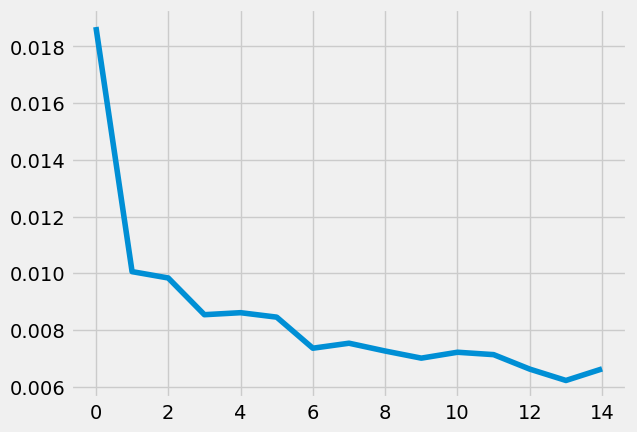

In [13]:
# File path to save/load the model
model_file_path = "MSFT_HMM_LSTM.h5"

if os.path.exists(model_file_path):
    print("Model exists. Loading the existing model...")
    final_model = keras.models.load_model(model_file_path)

else:
    # Train the final LSTM model using the best parameters
    final_model = Sequential()
    final_model.add(LSTM(best_params['units'], return_sequences=True, input_shape=(x_train.shape[1], 1)))
    final_model.add(LSTM(best_params['units']))
    final_model.add(Dense(200))
    final_model.add(Dropout(dropout_rate))
    final_model.add(Dense(100))
    final_model.add(Dropout(dropout_rate))
    final_model.add(Dense(1))
    final_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate']), loss='mean_squared_error')

    #train the model
    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3, min_lr=1e-4)
    t0 = time()
    history = final_model.fit(x_train,y_train,epochs=15,callbacks=[reduce_lr])
    print("done in %0.3fs" % (time() - t0))  
    final_model.save("MSFT_LSTM.h5")
    print(plt.plot(history.history['loss']))

This part builds and trains the final LSTM model using the best hyperparameters found through grid search. The model architecture consists of two LSTM layers followed by Dense layers with dropout regularization. It uses the Adam optimizer and mean squared error loss.

In [14]:
final_model.summary()

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_54 (LSTM)                  │ (None, 60, 200)        │       161,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_55 (LSTM)                  │ (None, 200)            │       320,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,628,405 (6.21 MB)

 Trainable params: 542,801 (2.07 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,085,604 (4.14 MB)

In [15]:
# # Evaluate the final model on the test set
# final_score = final_model.evaluate(x_test, y_test, verbose=0)

# # print("Best Hyperparameters:", best_params)
# # print("Final Model Score:", final_score)

The code snippet above evaluates the final LSTM model on the test set and computes the loss value.

248/248 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step


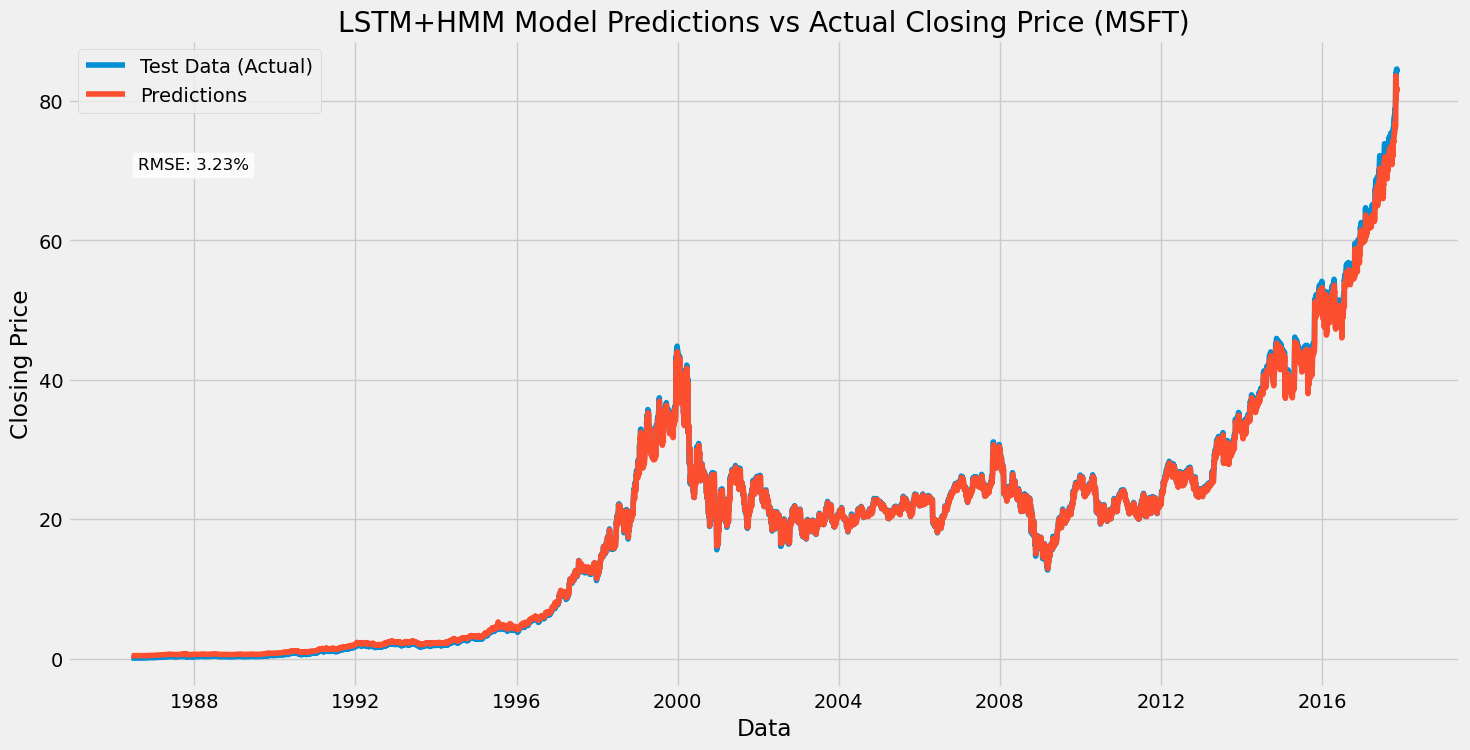

103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step


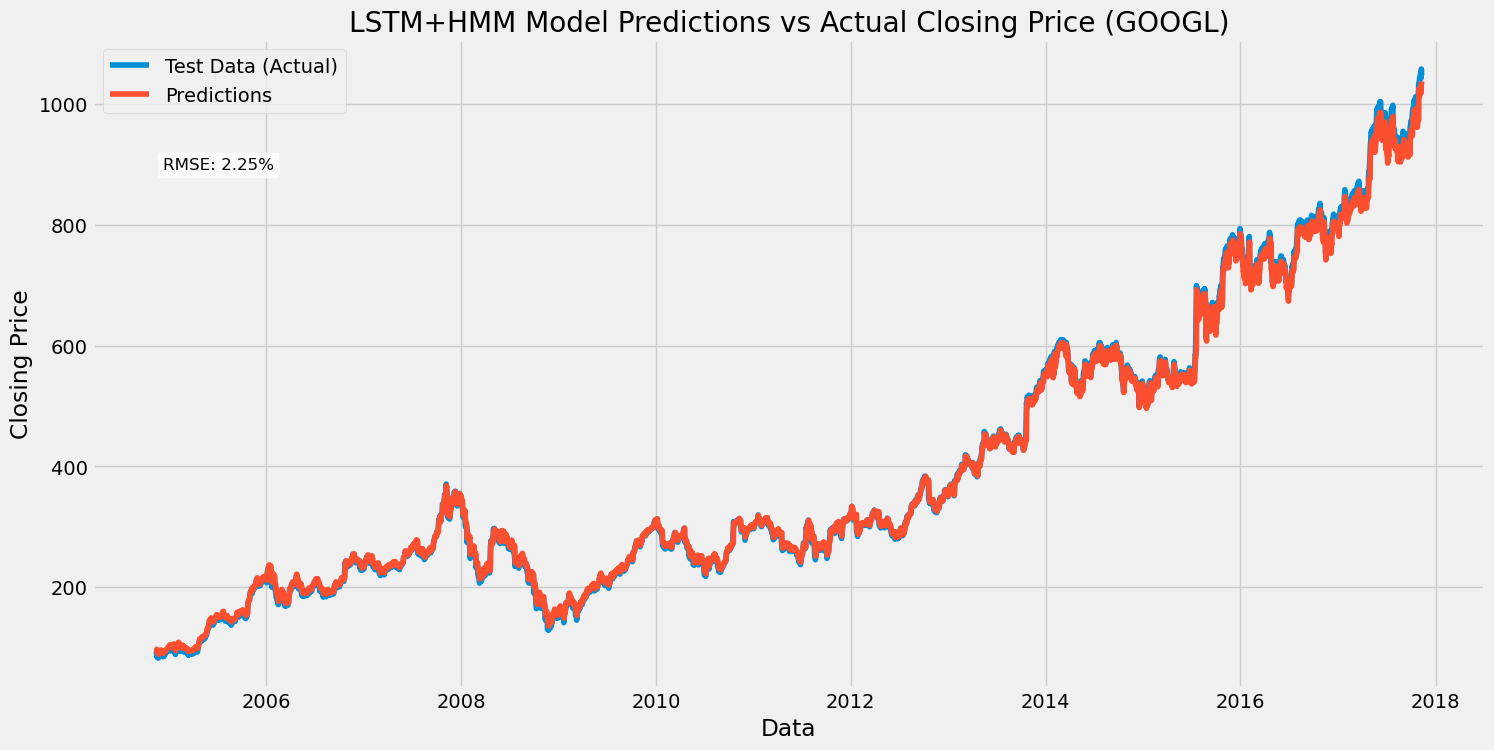

43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


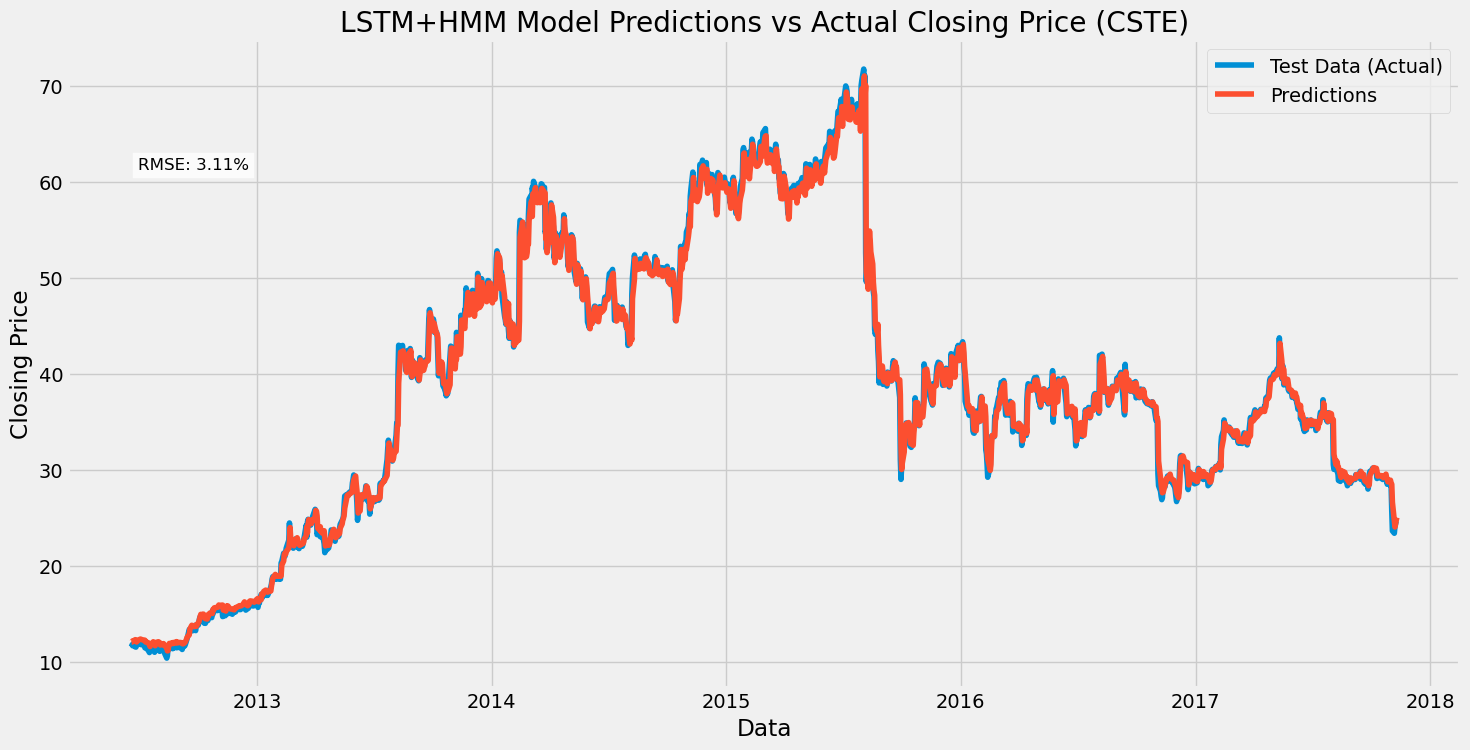

In [16]:
# Load the dataset
def load_data(filepath):
    data = pd.read_csv(filepath)
    data = data[['Date', 'Close']]
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)
    return data

# Preprocess the data
def preprocess_data(data, scaler=None):
    if scaler is None:
        scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    return scaled_data, scaler

# Create dataset for LSTM
def create_dataset(dataset, time_step=1):
    data_x, data_y = [], []
    for i in range(len(dataset)-time_step-1):
        data_x.append(dataset[i:(i+time_step), 0])
        data_y.append(dataset[i + time_step, 0])
    return np.array(data_x), np.array(data_y)

# Make predictions and plot results
def predict_and_plot(data, model, scaler, time_step, title):
    # Prepare test data
    scaled_data, scaler = preprocess_data(data, scaler)
    x_test, y_test = create_dataset(scaled_data, time_step)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    # Make predictions using the trained LSTM model
    predictions = model.predict(x_test)

    # Inverse scaling (if necessary)
    predictions = scaler.inverse_transform(predictions)
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, predictions))

    # Calculate RMSE as a percentage
    mean_actual = np.mean(y_test)
    rmse_percentage = (rmse / mean_actual) * 100

    # Prepare data for plotting
    valid_data_len = len(data)
    prediction_start_index = len(data) - valid_data_len + time_step + 1

    # Create DataFrame for predictions
    predictions_df = pd.DataFrame(predictions, index=data.index[prediction_start_index:prediction_start_index+len(predictions)], columns=['Predictions'])

    # Visualize the predictions with RMSE percentage
    plt.figure(figsize=(16, 8))
    plt.title(title)

    # Plot test data
    plt.plot(data.index[prediction_start_index:prediction_start_index+len(y_test)], y_test, label='Test Data (Actual)')

    # Plot predictions
    plt.plot(predictions_df.index, predictions_df['Predictions'], label='Predictions')

    # Annotate RMSE percentage
    plt.text(0.05, 0.8, f"RMSE: {rmse_percentage:.2f}%", transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

    plt.xlabel('Data')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.show()

# Example usage with multiple datasets
filepaths = {
    'MSFT': 'Huge Stock Market/Stocks/msft.us.txt',
    'GOOGL': 'Huge Stock Market/Stocks/googl.us.txt',
    'CSTE': 'Huge Stock Market/Stocks/cste.us.txt'
}

time_step = 60
for name, filepath in filepaths.items():
    data = load_data(filepath)
    predict_and_plot(data, final_model, None, time_step, f'LSTM+HMM Model Predictions vs Actual Closing Price ({name})')


This section prepares the data for visualization and plots the actual and predicted closing prices. It first creates a DataFrame (predictions_df) to store the predicted values with appropriate indices, then plots the actual train and test data along with the predictions.